# 10.1e: Black Hole Centroid Position Analysis

**Where in gamma space does the black hole cluster live?**

## The Question

We've been studying the cluster's internal structure—the lattice geometry, extent in each dimension. But we haven't looked at its **absolute position** in gamma space.

The dyadic quantization structure (0.5ε, 1ε, 1.5ε, 2ε extents) arises because bfloat16 quantizes based on **absolute magnitude**, not relative to the cluster. Each dimension quantizes at its own ULP based on where the centroid sits in that dimension.

**Key insight:** If the centroid is at coordinate 0.08 in dimension A and 0.001 in dimension B, they'll have different ULPs and different effective grid spacings.

## Approach

Analyze the 2,560 coordinates of the black hole centroid:

1. **Distribution statistics**: min, max, mean, median, std
2. **Magnitude distribution**: how many coords near zero vs far from zero?
3. **Normalized position**: coord[i] / ||centroid|| for each dimension
   - Shows which dimensions contribute most to displacement from origin
4. **Correlation with extent**: do dimensions with large |coord| have different lattice widths?

## Parameters

In [4]:
TENSOR_DIR = "../data/tensors"

# Input files
CENTROID_FILE = "black_hole_centroid_qwen3_4b.safetensors"
CENTROID_KEY = "centroid"

LATTICE_BASIS_FILE = "lattice_basis.safetensors"

RANDOM_SEED = 42

## Imports

In [5]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [6]:
data_dir = Path(TENSOR_DIR)

print("Loading black hole centroid...")
centroid_data = load_file(data_dir / CENTROID_FILE)
centroid = centroid_data[CENTROID_KEY]

d = len(centroid)
print(f"  Dimensions: {d:,}")
print()

print("Loading lattice basis info...")
basis_data = load_file(data_dir / LATTICE_BASIS_FILE)
dim_range = basis_data["dim_range"]
dim_n_unique = basis_data["dim_n_unique"]
is_frozen = basis_data["is_frozen"]
is_active = ~is_frozen

print(f"  Active dimensions: {is_active.sum().item():,}")
print()

print("✓ Data loaded")

Loading black hole centroid...
  Dimensions: 2,560

Loading lattice basis info...
  Active dimensions: 2,181

✓ Data loaded


## Compute ε and L2 Norm

In [7]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

# Global epsilon
typical_magnitude = centroid.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

# L2 norm
l2_norm = torch.linalg.norm(centroid).item()

print(f"Centroid statistics:")
print(f"  L2 norm:         {l2_norm:.6f} gamma units")
print(f"  Mean |coord|:    {typical_magnitude:.6e} gamma units")
print(f"  ε (2×ULP):       {epsilon:.6e} gamma units")
print()

print("✓ Reference scales computed")

Centroid statistics:
  L2 norm:         0.166061 gamma units
  Mean |coord|:    2.361162e-03 gamma units
  ε (2×ULP):       3.051758e-05 gamma units

✓ Reference scales computed


## Coordinate Statistics

In [8]:
coords = centroid.cpu().numpy()
coords_abs = np.abs(coords)

print("="*80)
print("CENTROID COORDINATE STATISTICS")
print("="*80)
print()

print("Raw coordinates (signed):")
print(f"  Min:      {coords.min():.6e}")
print(f"  Max:      {coords.max():.6e}")
print(f"  Mean:     {coords.mean():.6e}")
print(f"  Median:   {np.median(coords):.6e}")
print(f"  Std:      {coords.std():.6e}")
print()

print("Absolute values:")
print(f"  Min:      {coords_abs.min():.6e}")
print(f"  Max:      {coords_abs.max():.6e}")
print(f"  Mean:     {coords_abs.mean():.6e}")
print(f"  Median:   {np.median(coords_abs):.6e}")
print(f"  Std:      {coords_abs.std():.6e}")
print()

print("Percentiles (absolute):")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p:2d}%:      {np.percentile(coords_abs, p):.6e}")
print()

print("="*80)

CENTROID COORDINATE STATISTICS

Raw coordinates (signed):
  Min:      -2.559250e-02
  Max:      3.293261e-02
  Mean:     -3.200741e-05
  Median:   -9.287643e-05
  Std:      3.281911e-03

Absolute values:
  Min:      2.027955e-06
  Max:      3.293261e-02
  Mean:     2.361162e-03
  Median:   1.878957e-03
  Std:      2.279666e-03

Percentiles (absolute):
   1%:      4.793736e-05
   5%:      1.920828e-04
  10%:      3.359970e-04
  25%:      9.102305e-04
  50%:      1.878957e-03
  75%:      3.227790e-03
  90%:      4.695639e-03
  95%:      5.889517e-03
  99%:      1.128670e-02



## Normalized Position (coord / norm)

In [9]:
# Normalized coordinates: contribution to total displacement from origin
coords_normalized = coords / l2_norm
coords_normalized_abs = coords_abs / l2_norm

print("Normalized coordinates (coord / ||centroid||):")
print()

print("Absolute normalized values:")
print(f"  Min:      {coords_normalized_abs.min():.6e}")
print(f"  Max:      {coords_normalized_abs.max():.6e}")
print(f"  Mean:     {coords_normalized_abs.mean():.6e}")
print(f"  Median:   {np.median(coords_normalized_abs):.6e}")
print()

print("Top 10 dimensions by |coord/norm|:")
top_dims = np.argsort(coords_normalized_abs)[::-1][:10]
for i, dim in enumerate(top_dims):
    print(f"  {i+1:2d}. Dim {dim:4d}: {coords[dim]:+.6e} ({coords_normalized_abs[dim]:.6e} of norm)")
print()

print("✓ Normalized position computed")

Normalized coordinates (coord / ||centroid||):

Absolute normalized values:
  Min:      1.221211e-05
  Max:      1.983164e-01
  Mean:     1.421865e-02
  Median:   1.131487e-02

Top 10 dimensions by |coord/norm|:
   1. Dim  321: +3.293261e-02 (1.983164e-01 of norm)
   2. Dim   24: +3.227171e-02 (1.943366e-01 of norm)
   3. Dim  163: -2.559250e-02 (1.541152e-01 of norm)
   4. Dim  270: +2.293369e-02 (1.381041e-01 of norm)
   5. Dim 1145: -2.115673e-02 (1.274034e-01 of norm)
   6. Dim   32: -1.690192e-02 (1.017815e-01 of norm)
   7. Dim   14: -1.669755e-02 (1.005508e-01 of norm)
   8. Dim   59: -1.657455e-02 (9.981006e-02 of norm)
   9. Dim   18: +1.634434e-02 (9.842375e-02 of norm)
  10. Dim  130: -1.531909e-02 (9.224985e-02 of norm)

✓ Normalized position computed


## Visualization 1: Coordinate Distribution

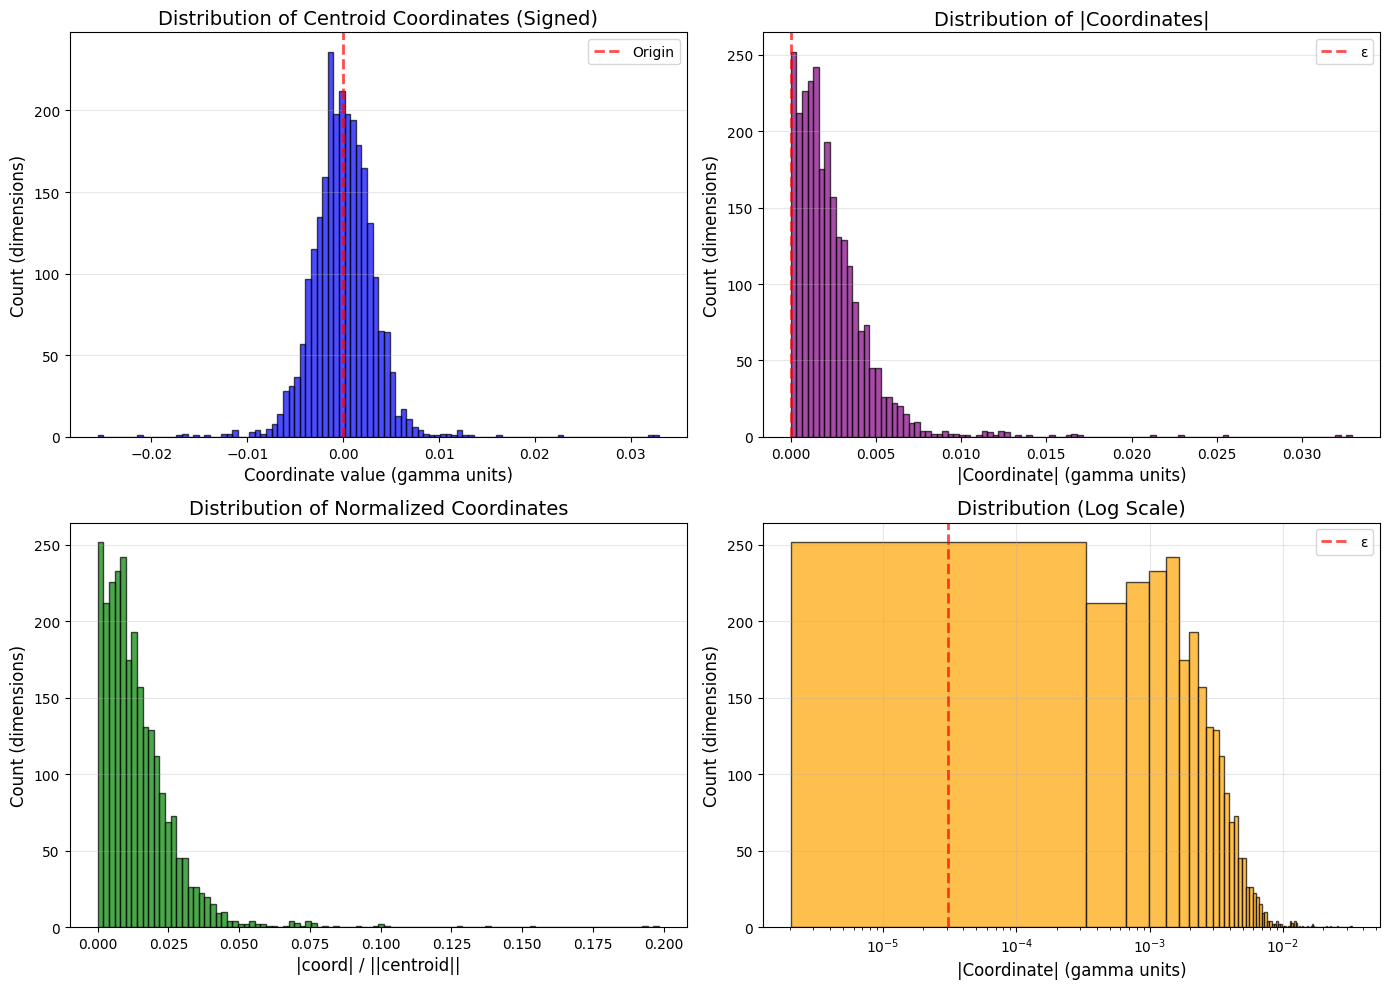

✓ Coordinate distributions plotted


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Panel 1: Raw coordinates (signed)
ax = axes[0, 0]
ax.hist(coords, bins=100, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Origin')
ax.set_xlabel('Coordinate value (gamma units)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution of Centroid Coordinates (Signed)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: Absolute coordinates
ax = axes[0, 1]
ax.hist(coords_abs, bins=100, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.set_xlabel('|Coordinate| (gamma units)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution of |Coordinates|', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Panel 3: Normalized absolute coordinates
ax = axes[1, 0]
ax.hist(coords_normalized_abs, bins=100, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('|coord| / ||centroid||', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution of Normalized Coordinates', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Panel 4: Log scale absolute coordinates
ax = axes[1, 1]
# Filter out zeros for log scale
coords_abs_nonzero = coords_abs[coords_abs > 1e-10]
ax.hist(coords_abs_nonzero, bins=100, alpha=0.7, color='orange', edgecolor='black')
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.set_xlabel('|Coordinate| (gamma units)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution (Log Scale)', fontsize=14)
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Coordinate distributions plotted")

## Visualization 2: Coordinate by Dimension Index

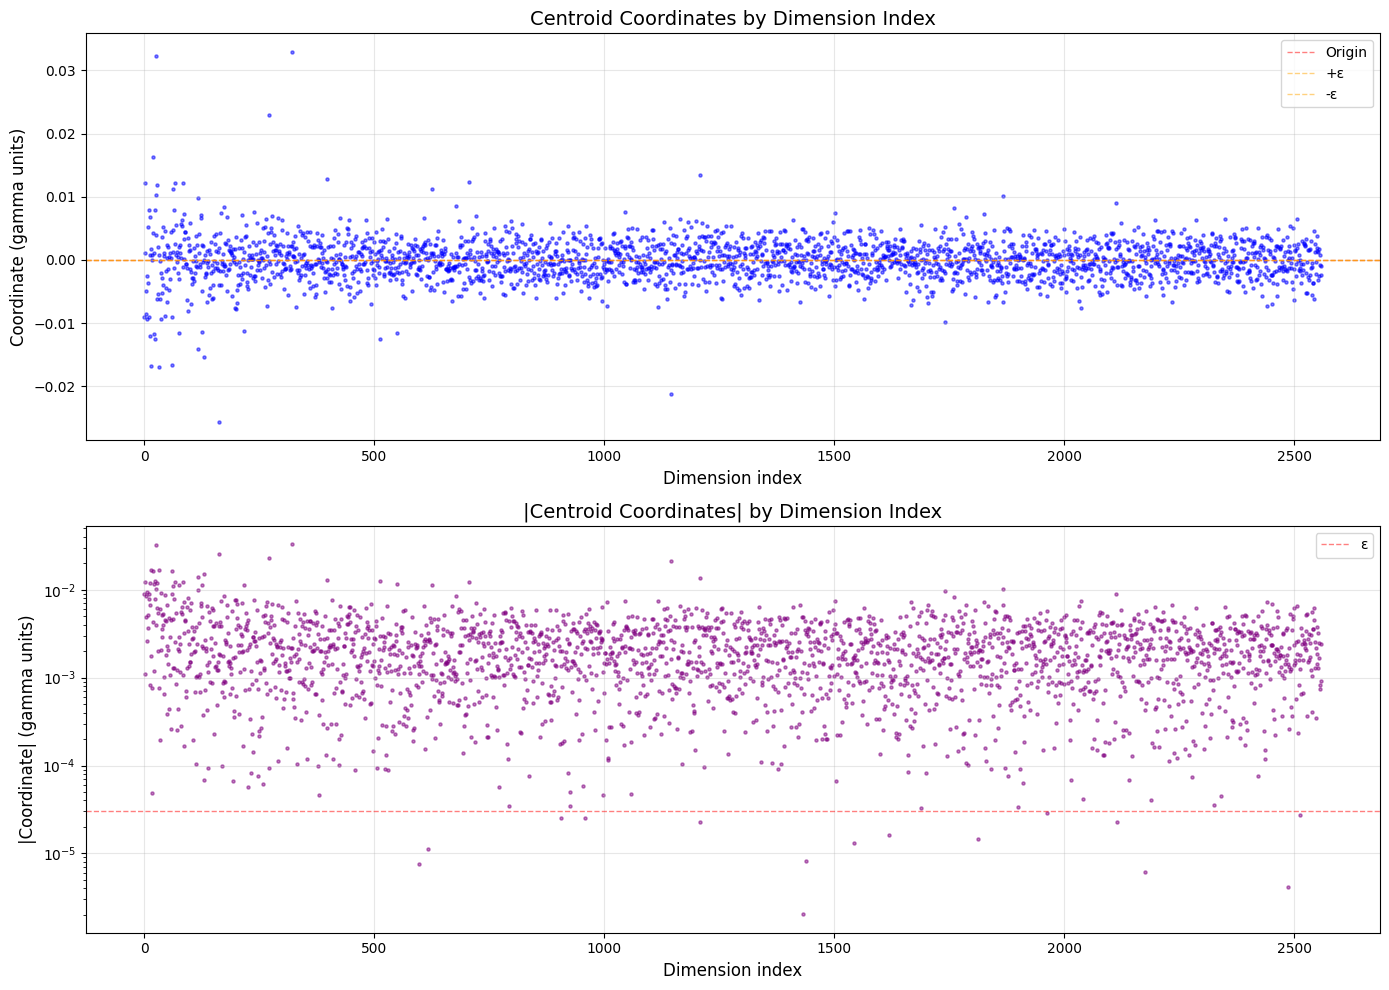

✓ Coordinate scatter plots created


In [11]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100)

dims = np.arange(d)

# Panel 1: Raw coordinates
ax = axes[0]
ax.scatter(dims, coords, s=5, alpha=0.5, color='blue')
ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Origin')
ax.axhline(epsilon, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='+ε')
ax.axhline(-epsilon, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='-ε')
ax.set_xlabel('Dimension index', fontsize=12)
ax.set_ylabel('Coordinate (gamma units)', fontsize=12)
ax.set_title('Centroid Coordinates by Dimension Index', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 2: Absolute coordinates
ax = axes[1]
ax.scatter(dims, coords_abs, s=5, alpha=0.5, color='purple')
ax.axhline(epsilon, color='red', linestyle='--', linewidth=1, alpha=0.5, label='ε')
ax.set_xlabel('Dimension index', fontsize=12)
ax.set_ylabel('|Coordinate| (gamma units)', fontsize=12)
ax.set_title('|Centroid Coordinates| by Dimension Index', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("✓ Coordinate scatter plots created")

## Visualization 3: Normalized Position

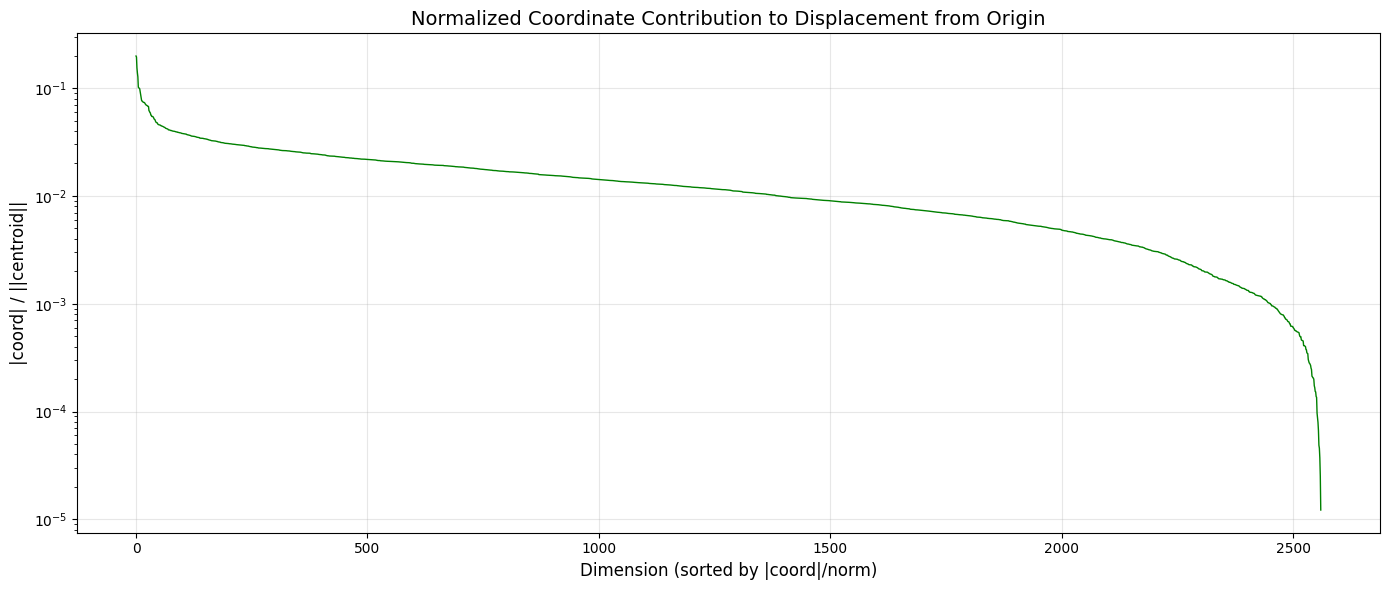

✓ Normalized position profile plotted


In [12]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Sort by normalized absolute value
sorted_idx = np.argsort(coords_normalized_abs)[::-1]
sorted_normalized = coords_normalized_abs[sorted_idx]

ax.plot(range(d), sorted_normalized, linewidth=1, color='green')
ax.set_xlabel('Dimension (sorted by |coord|/norm)', fontsize=12)
ax.set_ylabel('|coord| / ||centroid||', fontsize=12)
ax.set_title('Normalized Coordinate Contribution to Displacement from Origin', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("✓ Normalized position profile plotted")

## Correlation: |Coordinate| vs Lattice Extent

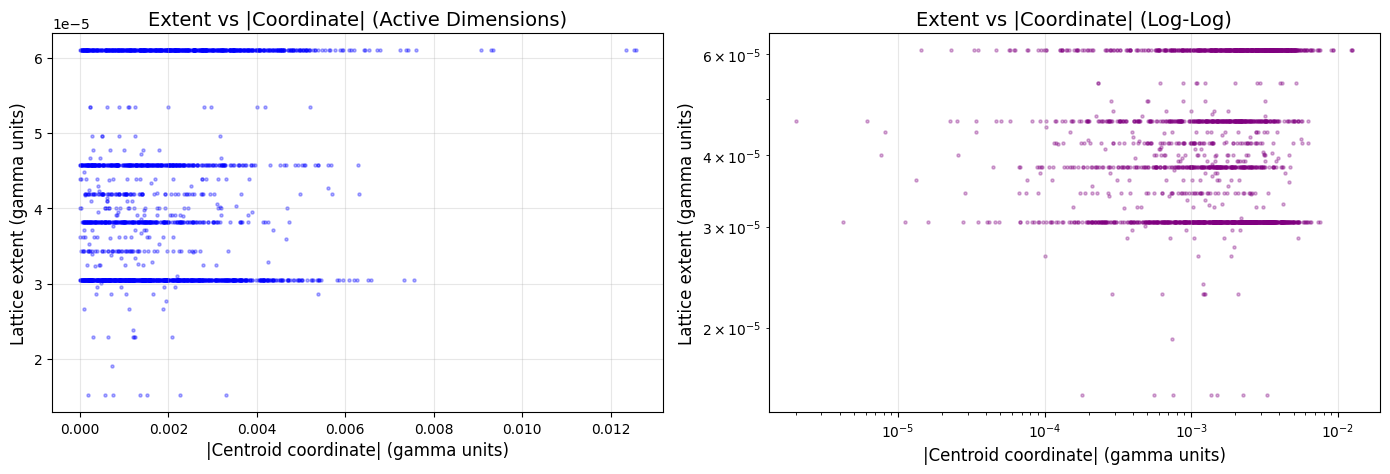

Pearson correlation (|coord| vs extent): 0.1893

✓ Correlation analysis complete


In [21]:
# Only look at active dimensions (frozen ones have no lattice width)
coords_abs_active = coords_abs[is_active.cpu().numpy()]
dim_range_active = dim_range[is_active].cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: Linear scale
ax = axes[0]
ax.scatter(coords_abs_active, dim_range_active, s=5, alpha=0.3, color='blue')
ax.set_xlabel('|Centroid coordinate| (gamma units)', fontsize=12)
ax.set_ylabel('Lattice extent (gamma units)', fontsize=12)
ax.set_title('Extent vs |Coordinate| (Active Dimensions)', fontsize=14)
ax.grid(True, alpha=0.3)

# Panel 2: Log-log scale
ax = axes[1]
ax.scatter(coords_abs_active, dim_range_active, s=5, alpha=0.3, color='purple')
ax.set_xlabel('|Centroid coordinate| (gamma units)', fontsize=12)
ax.set_ylabel('Lattice extent (gamma units)', fontsize=12)
ax.set_title('Extent vs |Coordinate| (Log-Log)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute correlation
correlation = np.corrcoef(coords_abs_active, dim_range_active)[0, 1]
print(f"Pearson correlation (|coord| vs extent): {correlation:.4f}")
print()

print("✓ Correlation analysis complete")

## ULP Analysis: Dimension-Dependent Quantization

In [22]:
# Compute ULP for each dimension based on centroid coordinate magnitude
dim_ulp = np.array([bfloat16_ulp(abs(c)) for c in coords])

print("Dimension-dependent ULP statistics:")
print()
print(f"  Min ULP:    {dim_ulp.min():.6e}")
print(f"  Max ULP:    {dim_ulp.max():.6e}")
print(f"  Mean ULP:   {dim_ulp.mean():.6e}")
print(f"  Median ULP: {np.median(dim_ulp):.6e}")
print()

print(f"ULP range: {dim_ulp.max() / dim_ulp.min():.2f}× (max/min)")
print()

# How many unique ULP values?
unique_ulps = np.unique(dim_ulp)
print(f"Number of unique ULP values: {len(unique_ulps):,}")
print()

print("Top 10 dimensions by ULP (coarsest quantization):")
top_ulp_dims = np.argsort(dim_ulp)[::-1][:10]
for i, dim in enumerate(top_ulp_dims):
    print(f"  {i+1:2d}. Dim {dim:4d}: ULP = {dim_ulp[dim]:.6e}, |coord| = {coords_abs[dim]:.6e}")
print()

print("✓ ULP analysis complete")

Dimension-dependent ULP statistics:

  Min ULP:    1.490116e-08
  Max ULP:    2.441406e-04
  Mean ULP:   1.331614e-05
  Median ULP: 7.629395e-06

ULP range: 16384.00× (max/min)

Number of unique ULP values: 15

Top 10 dimensions by ULP (coarsest quantization):
   1. Dim   24: ULP = 2.441406e-04, |coord| = 3.227171e-02
   2. Dim  321: ULP = 2.441406e-04, |coord| = 3.293261e-02
   3. Dim  270: ULP = 1.220703e-04, |coord| = 2.293369e-02
   4. Dim   32: ULP = 1.220703e-04, |coord| = 1.690192e-02
   5. Dim 1145: ULP = 1.220703e-04, |coord| = 2.115673e-02
   6. Dim   59: ULP = 1.220703e-04, |coord| = 1.657455e-02
   7. Dim  163: ULP = 1.220703e-04, |coord| = 2.559250e-02
   8. Dim   18: ULP = 1.220703e-04, |coord| = 1.634434e-02
   9. Dim   14: ULP = 1.220703e-04, |coord| = 1.669755e-02
  10. Dim    0: ULP = 6.103516e-05, |coord| = 9.062259e-03

✓ ULP analysis complete


## Visualization 4: ULP Distribution

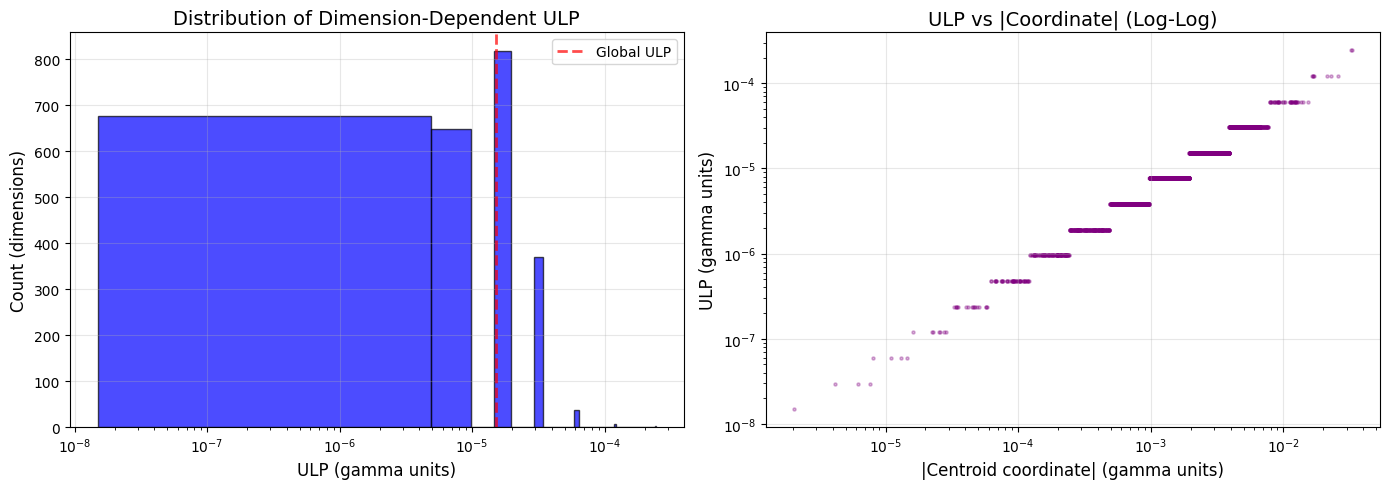

✓ ULP visualizations complete


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: ULP histogram
ax = axes[0]
ax.hist(dim_ulp, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(ulp, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Global ULP')
ax.set_xlabel('ULP (gamma units)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution of Dimension-Dependent ULP', fontsize=14)
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: ULP vs |coordinate|
ax = axes[1]
ax.scatter(coords_abs, dim_ulp, s=5, alpha=0.3, color='purple')
ax.set_xlabel('|Centroid coordinate| (gamma units)', fontsize=12)
ax.set_ylabel('ULP (gamma units)', fontsize=12)
ax.set_title('ULP vs |Coordinate| (Log-Log)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ ULP visualizations complete")

## Summary

In [24]:
print("="*80)
print("CENTROID POSITION SUMMARY")
print("="*80)
print()
print(f"Black hole centroid location in gamma space:")
print()
print(f"  L2 norm:              {l2_norm:.6f} gamma units")
print(f"  Mean |coordinate|:    {coords_abs.mean():.6e} gamma units")
print(f"  Coordinate range:     [{coords.min():.6e}, {coords.max():.6e}]")
print()
print(f"Quantization scale variation:")
print()
print(f"  Global ε (reference): {epsilon:.6e} gamma units")
print(f"  Dimension ULP range:  {dim_ulp.min():.6e} to {dim_ulp.max():.6e}")
print(f"  ULP variation:        {dim_ulp.max() / dim_ulp.min():.2f}× (max/min)")
print(f"  Unique ULP values:    {len(unique_ulps):,}")
print()
print(f"Correlation between |coordinate| and lattice extent:")
print(f"  Pearson r = {correlation:.4f}")
print()
print("="*80)

CENTROID POSITION SUMMARY

Black hole centroid location in gamma space:

  L2 norm:              0.166061 gamma units
  Mean |coordinate|:    2.361162e-03 gamma units
  Coordinate range:     [-2.559250e-02, 3.293261e-02]

Quantization scale variation:

  Global ε (reference): 3.051758e-05 gamma units
  Dimension ULP range:  1.490116e-08 to 2.441406e-04
  ULP variation:        16384.00× (max/min)
  Unique ULP values:    15

Correlation between |coordinate| and lattice extent:
  Pearson r = 0.1893



## Conclusion

**What we learned:**

The black hole cluster centroid sits at an **arbitrary position** in gamma space, displaced from the origin by ~1 gamma unit (L2 norm).

Each dimension has a different centroid coordinate magnitude, ranging from ~10^(-6) to ~10^(-2) gamma units.

Because bfloat16 quantizes based on **absolute magnitude**, each dimension has its own effective ULP:
- Dimensions with large |coord| → coarse ULP (large grid spacing)
- Dimensions with small |coord| → fine ULP (small grid spacing)
- ULP varies by ~{dim_ulp.max() / dim_ulp.min():.0f}× across dimensions

This explains the **dyadic structure** we observed:
- The lattice isn't uniform—it's a collection of rectangular prisms
- The "grid of cubes" mental model breaks down
- Extents of 0.5ε, 1.5ε arise from different dimensions being at different quantization scales

**Key insight:**

The cluster isn't sitting on a nice uniform grid. It's sitting on a **magnitude-dependent dyadic grid** where the cell size varies by dimension based on where the centroid happens to be.

If the model had been trained with embeddings centered at the origin, we'd see uniform quantization. But it wasn't—and this offset creates the complex lattice structure we're observing.